# Tabular Montecarlo First Visit

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

# Create the environment
def create_env():
    return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case

# Initialize Q-table
def initialize_q_table(env):
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon=0.01):
    return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))

# Choose action based on epsilon-greedy policy
def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

# Generate an episode
def Generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = choose_action(q_table, state, epsilon, env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append([state, action, reward])
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward

# Monte Carlo algorithm
def Monte_Carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    visits_counter = np.zeros_like(q_table)
    rewards = []
    
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon)
        trajectory, total_reward = Generate_episode(epsilon, q_table, env, max_env_steps)
        G = 0
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            G = gamma * G + reward
            
            # Convert state to integer if it's a dictionary
            if isinstance(state, dict):
                state = state.get('state_key', 0)  # Adjust 'state_key' to the appropriate key in your dictionary
            
            # first-visit MC
            if not [state, action] in [[x[0], x[1]] for x in trajectory[0:t]]:
                
                if isinstance(state, tuple):
                    state = state[0]  # Adjust for your state representation
                                    
                visits_counter[state, action] += 1
                q_table[state, action] += (G - q_table[state, action]) / visits_counter[state, action]
        
        if episode % 50 == 0:
            rewards.append(total_reward)
            print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    
    rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards

# Plotting the training rewards
def plot_rewards(rewards, title, save_path):
    x = np.linspace(0, len(rewards) * 50, len(rewards))
    plt.plot(x, rewards, label='Monte Carlo')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig(save_path)
    plt.show()

# Testing the policy
def test_policy(env, q_table, num_episodes=10):
    rewards = []
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(num_episodes):
        state = env.reset()
        total_rewards = 0
        done = False
        
        for step in range(max_env_steps):
            if isinstance(state, tuple):
                state = state[0]

            action = np.argmax(q_table[state])
            state, reward, done, info, _ = env.step(action)
            total_rewards += reward
            env.render()
            if done:
                env.render()
                break
        
        rewards.append(total_rewards)
        print(f"Episode {episode}, reward {total_rewards}")
    
    print(f"Average score: {np.mean(rewards)}")


    



 ********** Training number 0
Episode 0, epsilon 1.0000, reward 0.00
Episode 50, epsilon 1.0000, reward 0.00
Episode 100, epsilon 1.0000, reward 0.00
Episode 150, epsilon 1.0000, reward 0.00
Episode 200, epsilon 1.0000, reward 0.00
Episode 250, epsilon 1.0000, reward 0.00
Episode 300, epsilon 1.0000, reward 0.00
Episode 350, epsilon 1.0000, reward 0.00
Episode 400, epsilon 1.0000, reward 0.00
Episode 450, epsilon 1.0000, reward 0.00
Episode 500, epsilon 1.0000, reward 0.00
Episode 550, epsilon 1.0000, reward 0.00
Episode 600, epsilon 1.0000, reward 0.00
Episode 650, epsilon 1.0000, reward 0.00
Episode 700, epsilon 1.0000, reward 0.00
Episode 750, epsilon 1.0000, reward 0.00
Episode 800, epsilon 1.0000, reward 0.00
Episode 850, epsilon 1.0000, reward 0.00
Episode 900, epsilon 1.0000, reward 0.00
Episode 950, epsilon 1.0000, reward 0.00
Episode 1000, epsilon 0.9996, reward 0.00
Episode 1050, epsilon 0.9784, reward 0.00
Episode 1100, epsilon 0.9582, reward 0.00
Episode 1150, epsilon 0.93

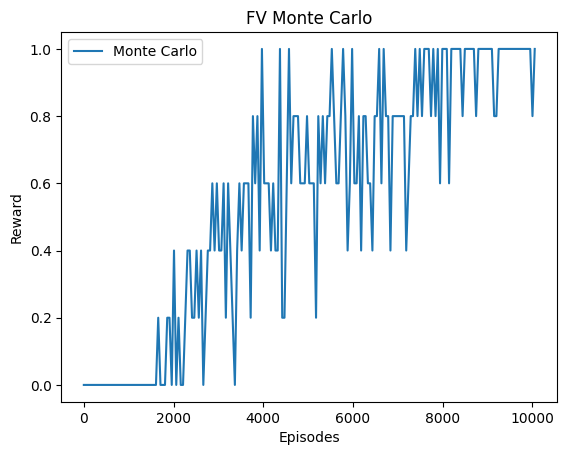

Episode 0, reward 1.0
Average score: 1.0


In [2]:
# Main code
if __name__ == "__main__":
    n_times = 5
    total_train_episodes = 10000
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01

    env = create_env()

    MC_tables = []
    MC_rewards = []

    for number in range(n_times):
        print(f"\n ********** Training number {number}")
        q_table, rewards = Monte_Carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        MC_tables.append(q_table)
        MC_rewards.append(rewards)

    # we perform the mean of the rewards and the Q-tables to reduce variance
    MC_mean = np.mean(np.array(MC_rewards), axis=0)
    MC_mean_table = np.mean(np.array(MC_tables), axis=0)
    np.save('ON/imgs/MC_mean_FV.npy', MC_mean)
    np.save('ON/models/MC_tables_FV.npy', MC_mean_table)

    plot_rewards(MC_mean, 'FV Monte Carlo', 'ON/imgs/FV_rewards.png')

    # Load Q-tables and test
    q_table = np.load('ON/models/MC_tables_FV.npy', allow_pickle=True)
    #q_table = q_tables[0]
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="human")
    test_policy(env, q_table, num_episodes=1)
    
    env.close()


# Tabular MonteCarlo Every Visit

In [3]:
# Monte Carlo algorithm - Every Visit Version
def Monte_Carlo_Every_Visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    visits_counter = np.zeros_like(q_table)
    rewards = []
    
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon)
        trajectory, total_reward = Generate_episode(epsilon, q_table, env, max_env_steps)
        G = 0
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            G = gamma * G + reward
            
            if isinstance(state, dict):
                state = state.get('state_key', 0)  # Adjust 'state_key' to the appropriate key in your dictionary
            
            if isinstance(state, tuple):
                state = state[0]  # Adjust for your state representation

            # every-visit MC    
            visits_counter[state, action] += 1
            q_table[state, action] += (G - q_table[state, action]) / visits_counter[state, action]
        
        if episode % 50 == 0:
            rewards.append(total_reward)
            print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    
    rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards



 ********** Training number 0
Episode 0, epsilon 1.0000, reward 0.00
Episode 50, epsilon 1.0000, reward 0.00
Episode 100, epsilon 0.9957, reward 0.00
Episode 150, epsilon 0.8210, reward 0.00
Episode 200, epsilon 0.6968, reward 1.00
Episode 250, epsilon 0.6003, reward 1.00
Episode 300, epsilon 0.5214, reward 0.00
Episode 350, epsilon 0.4547, reward 0.00
Episode 400, epsilon 0.3969, reward 0.00
Episode 450, epsilon 0.3458, reward 0.00
Episode 500, epsilon 0.3002, reward 0.00
Episode 550, epsilon 0.2588, reward 1.00
Episode 600, epsilon 0.2211, reward 1.00
Episode 650, epsilon 0.1864, reward 1.00
Episode 700, epsilon 0.1543, reward 0.00
Episode 750, epsilon 0.1244, reward 1.00
Episode 800, epsilon 0.0964, reward 1.00
Episode 850, epsilon 0.0701, reward 1.00
Episode 900, epsilon 0.0453, reward 1.00
Episode 950, epsilon 0.0218, reward 1.00
Episode 999, epsilon 0.0100, reward 1.00

 ********** Training number 1
Episode 0, epsilon 1.0000, reward 0.00
Episode 50, epsilon 1.0000, reward 0.00
E

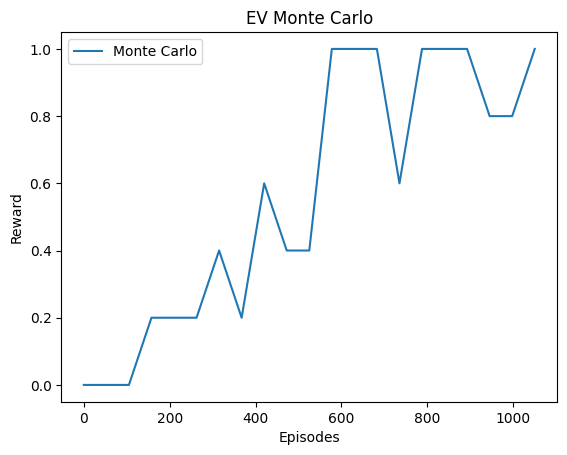

Episode 0, reward 1.0
Average score: 1.0


In [4]:
# Main code
if __name__ == "__main__":
    n_times = 5
    total_train_episodes = 1000
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01

    env = create_env()

    MC_tables = []
    MC_rewards = []

    for number in range(n_times):
        print(f"\n ********** Training number {number}")
        q_table, rewards = Monte_Carlo_Every_Visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        MC_tables.append(q_table)
        MC_rewards.append(rewards)

    MC_mean = np.mean(np.array(MC_rewards), axis=0)
    MC_mean_tables = np.mean(np.array(MC_tables), axis=0)
    np.save('ON/models/MC_mean_EV.npy', MC_mean)
    np.save('ON/models/MC_tables_EV.npy', MC_mean_tables)

    plot_rewards(MC_mean, 'EV Monte Carlo', 'ON/imgs/EV_rewards.png')

    # Load Q-tables and test
    q_table = np.load('ON/models/MC_tables_EV.npy', allow_pickle=True)
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="human")
    test_policy(env, q_table, num_episodes=1)
    
    env.close()


# Policy Plot

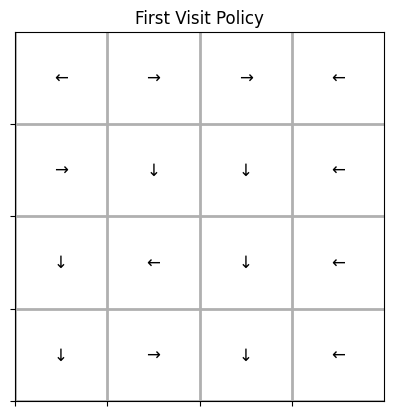

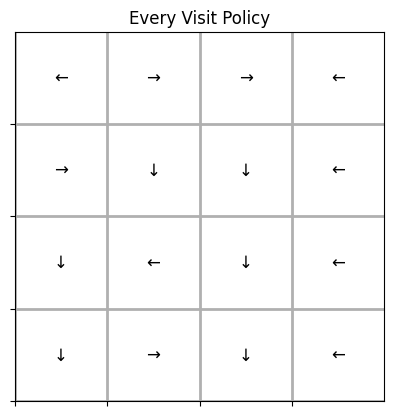

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_policy(q_table, grid_size=(4, 4), title='Policy', save_path=None):
    """
    Plots the policy learned by the Q-table on a grid using text labels for directions.

    Parameters:
        q_table (numpy.ndarray): The Q-table from which to derive the policy.
        grid_size (tuple): The size of the grid representing the environment (default is (4, 4)).
    """
    # Define direction labels
    direction_labels = {
        0: '←',  # left
        1: '↓',  # down
        2: '→',  # right
        3: '↑'   # up
    }

   
    policy = np.argmax(q_table, axis=1).reshape(grid_size)
    
    # Set up the grid
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size[1]))
    ax.set_yticks(np.arange(grid_size[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Create grid
    ax.grid(which='both', linestyle='-', linewidth=2)
    
    # Plot direction labels
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            action = policy[i, j]
            direction = direction_labels[action]
            ax.text(j + 0.5, i + 0.5, direction, 
                    ha='center', va='center', fontsize=12, color='black')

    # Set the aspect of the plot to equal
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    plt.savefig(save_path)
    plt.show()

# Usage example:
if __name__ == "__main__":
    # Assuming you have already saved your Q-tables as 'MC_tables.npy'
    FV_q_table = np.load('ON/models/MC_tables_FV.npy', allow_pickle=True)
    EV_q_table = np.load('ON/models/MC_tables_EV.npy', allow_pickle=True)
    
    plot_policy(FV_q_table, title='First Visit Policy', save_path='ON/imgs/FV_policy.png')
    plot_policy(EV_q_table, title='Every Visit Policy', save_path='ON/imgs/EV_policy.png')
